# **Third Simulation Analysis**

## **Requirements**

In [1]:
import pandas as pd
import polars as pl
import numpy as np
import sys
from sklearn_extra.cluster import KMedoids, CLARA
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, SpectralBiclustering, SpectralCoclustering, Birch, BisectingKMeans, MiniBatchKMeans, DBSCAN
from sklearn.manifold import MDS
from sklearn.mixture import GaussianMixture
import seaborn as sns
import matplotlib.pyplot as plt 
sns.set_style('whitegrid')
import time
import pickle
from sklearn.metrics import adjusted_rand_score
from sklearn.datasets import make_classification, make_blobs
from clustpy.partition import SubKmeans, LDAKmeans, DipInit
from clustpy.hierarchical import Diana

In [2]:
sys.path.insert(0, r'C:\Users\fscielzo\Documents\Packages\BigEDA_Package_Private')
from BigEDA.descriptive import outliers_table
from BigEDA.plots import boxplot_matrix, histogram_matrix, barplot_matrix

In [3]:
sys.path.insert(0, r'C:\Users\fscielzo\Documents\Packages\PyDistances_Package_Private')
from PyDistances.quantitative import Euclidean_dist_matrix

In [4]:
sys.path.insert(0, r'C:\Users\fscielzo\Documents\Packages\FastKmedoids_Package_Private')
from FastKmedoids.models import FastGG, FastKmedoidsGG, KFoldFastKmedoidsGG 
from FastKmedoids.plots import clustering_MDS_plot
from FastKmedoids.metrics import adjusted_accuracy
from FastKmedoids.data import outlier_contamination

## **Data**

- `make_blobs` with outlier contamination and 100k rows. (4 clusters)

In [5]:
X, Y = make_blobs(n_samples=100000, centers=4, cluster_std=[2,2,2,3], n_features=8, random_state=123)
X = pd.DataFrame(X)      
X.columns = [f"X{i}" for i in range(1, X.shape[1]+1)]

# Se convierten dos variables cuantitativas a binarias, y otras dos a multiclase, discretizandolas.
X['X5'] = pd.cut(X['X5'], bins=[X['X5'].min()-1, X['X5'].mean(), X['X5'].max()+1], labels=False)
X['X6'] = pd.cut(X['X6'], bins=[X['X6'].min()-1, X['X6'].mean(), X['X6'].max()+1], labels=False)
X['X7'] = pd.cut(X['X7'], bins=[X['X7'].min()-1, X['X7'].quantile(0.25), X['X7'].quantile(0.50), X['X7'].quantile(0.75), X['X7'].max()+1], labels=False)
X['X8'] = pd.cut(X['X8'], bins=[X['X8'].min()-1, X['X8'].quantile(0.25), X['X8'].quantile(0.50), X['X8'].quantile(0.75), X['X8'].max()+1], labels=False)   

X_not_outliers_pl = pl.from_pandas(X)
X_outliers = outlier_contamination(X, col='X1', below=False, above=True, prop_above=0.05, dil=2, random_state=123)
X_outliers = outlier_contamination(X_outliers, col='X2', above=False, below=True, prop_below=0.05, dil=2, random_state=123)
X_outliers_pl = pl.from_pandas(X_outliers)

X = X_outliers.copy()
X_np = X.to_numpy()

In [8]:
X_outliers_pl.head()

X1,X2,X3,X4,X5,X6,X7,X8
f64,f64,f64,f64,i64,i64,i64,i64
6.284108,-2.218508,-6.732578,0.352627,1,0,3,3
3.953901,-5.405226,-0.076778,0.958369,0,1,0,1
-0.732585,1.007679,1.217141,3.729691,0,0,2,3
5.735251,-6.170185,4.437365,-9.121148,0,0,0,2
3.597274,-7.497242,1.314502,-2.669496,0,1,0,0


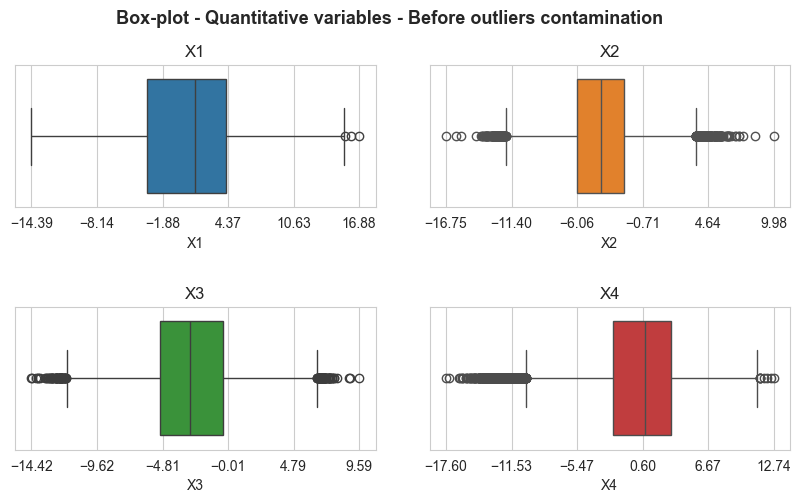

In [9]:
boxplot_matrix(X_not_outliers_pl, n_cols=2, title='Box-plot - Quantitative variables - Before outliers contamination', 
               figsize=(10,5), quant_col_names=['X1', 'X2', 'X3', 'X4'], n_xticks=6, title_fontsize=13, 
               save=True, file_name='plots/simu_3_boxplot_1', x_rotation=0, title_height=0.99,
               style='whitegrid', hspace=0.7, wspace=0.15, title_weight='bold',
               subtitles_fontsize=12, xlabel_size=10)

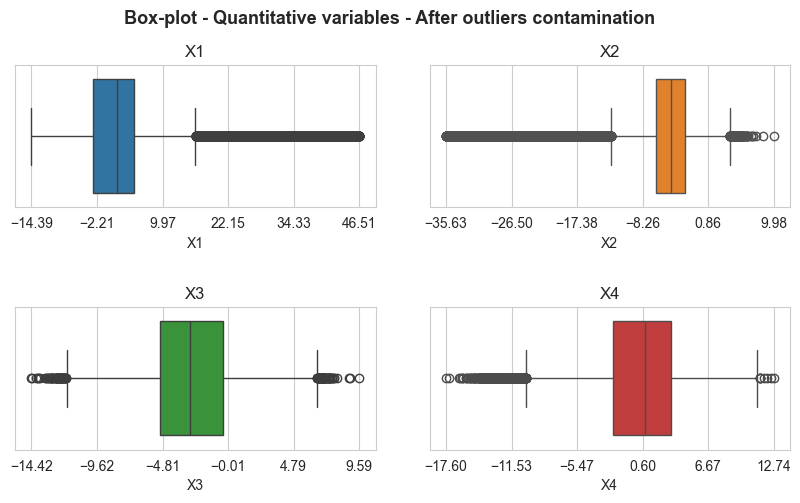

In [10]:
boxplot_matrix(X_outliers_pl, n_cols=2, title='Box-plot - Quantitative variables - After outliers contamination', 
               figsize=(10,5), quant_col_names=['X1', 'X2', 'X3', 'X4'], n_xticks=6, title_fontsize=13, 
               save=True, file_name='plots/simu_3_boxplot_2', x_rotation=0, title_height=0.99,
               style='whitegrid', hspace=0.7, wspace=0.15, title_weight='bold',
               subtitles_fontsize=12, xlabel_size=10)

In [11]:
outliers_table(X_outliers_pl, auto=False, col_names=['X1', 'X2', 'X3', 'X4'], h=1.5)

quant_variables,lower_bound,upper_bound,n_outliers,n_not_outliers,prop_outliers,prop_not_outliers
str,f64,f64,i64,i64,f64,f64
"""X1""",-14.436985,16.094229,4923,95077,0.04923,0.95077
"""X2""",-12.631825,3.882602,5046,94954,0.05046,0.94954
"""X3""",-11.877029,6.497705,116,99884,0.00116,0.99884
"""X4""",-10.228393,11.273816,1364,98636,0.01364,0.98636


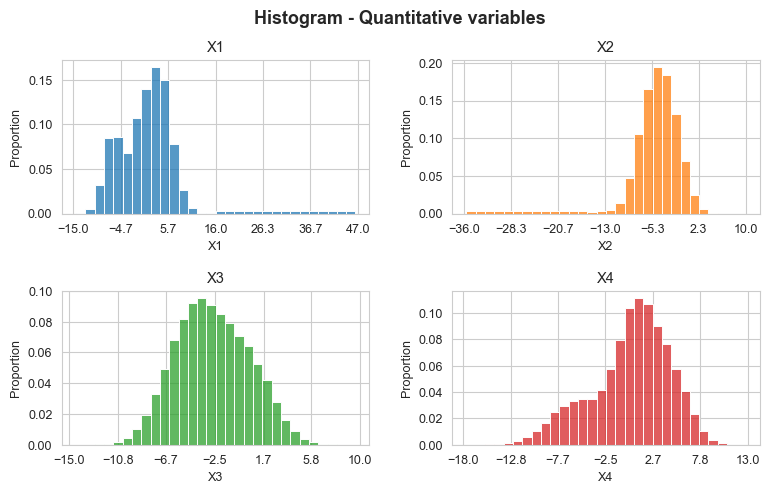

In [12]:
histogram_matrix(df=X_outliers_pl, bins=30, n_cols=2, title='Histogram - Quantitative variables', 
                 figsize=(9,5), quant_col_names=['X1', 'X2', 'X3', 'X4'], 
                 n_xticks=7, title_fontsize=13, 
                 subtitles_fontsize=10.5, save=True, file_name='plots/simu_3_hist', x_rotation=0, title_height=0.98,
                 style='whitegrid', hspace=0.5, wspace=0.27, n_round_xticks=1, xlabel_size=9, ylabel_size=9,
                 yticks_size=9, xticks_size=9)

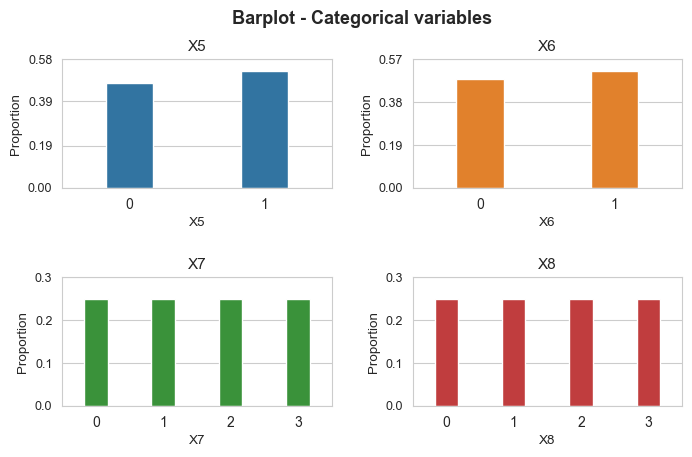

In [13]:
barplot_matrix(df=X_outliers_pl, n_cols=2, title='Barplot - Categorical variables', 
                 figsize=(8,4.5), cat_col_names=['X5', 'X6', 'X7', 'X8'], 
                 title_fontsize=13, subtitles_fontsize=11, 
                 save=True, file_name='plots/simu_3_barplot', x_rotation=0, title_height=0.99,
                 style='whitegrid', hspace=0.7, wspace=0.3, title_weight='bold', bar_width=0.35,
                 ylabel_size=9.5, xlabel_size=9.7, xticks_size=10, yticks_size=9)

## **Accuracy-Time vs Sample Size Analysis - Fast Kmedoids**

In [14]:
data_frac_sizes = np.array([0.0005, 0.001, 0.0025, 0.005, 0.01, 0.03, 0.05, 0.1, 0.2])

In [ ]:
'''
fast_kmedoids_dict, times = {}, {}

for frac_size in data_frac_sizes:
    print(frac_size)
    fast_kmedoids = FastKmedoidsGG(n_clusters=4, method='pam', init='heuristic', max_iter=100, random_state=123,
                                frac_sample_size=frac_size, p1=4, p2=2, p3=2, d1='robust_mahalanobis', d2='jaccard', d3='matching', 
                                robust_maha_method='trimmed', alpha=0.05, epsilon=0.05, n_iters=20,
                                VG_sample_size=1000, VG_n_samples=5)
    start_time = time.time()
    fast_kmedoids.fit(X=X) 
    end_time = time.time()
    fast_kmedoids_dict[frac_size] = fast_kmedoids
    times[frac_size] = end_time - start_time

cluster_labels = {frac_size: fast_kmedoids_dict[frac_size].labels for frac_size in data_frac_sizes}
'''

In [ ]:
'''
with open('results/clustrer_labels_simu_3.pkl', 'wb') as file:
    pickle.dump(cluster_labels, file)
with open('results/times_simu_3.pkl', 'wb') as file:
    pickle.dump(times, file)
'''

In [15]:
with open('results/clustrer_labels_simu_3.pkl', 'rb') as file:
    cluster_labels = pickle.load(file)
with open('results/times_simu_3.pkl', 'rb') as file:
    times = pickle.load(file)

In [16]:
best_accuracy, best_cluster_labels = {}, {}
for frac_size in data_frac_sizes:
    best_accuracy[frac_size], best_cluster_labels[frac_size] = adjusted_accuracy(y_pred=cluster_labels[frac_size], y_true=Y)

best_accuracy_values = np.array(list(best_accuracy.values()))
best_frac_size = data_frac_sizes[np.argmax(best_accuracy_values)]
times_values = np.array(list(times.values()))
data_perc_sizes = np.round(data_frac_sizes*100, 2)
best_perc_size = best_frac_size*100

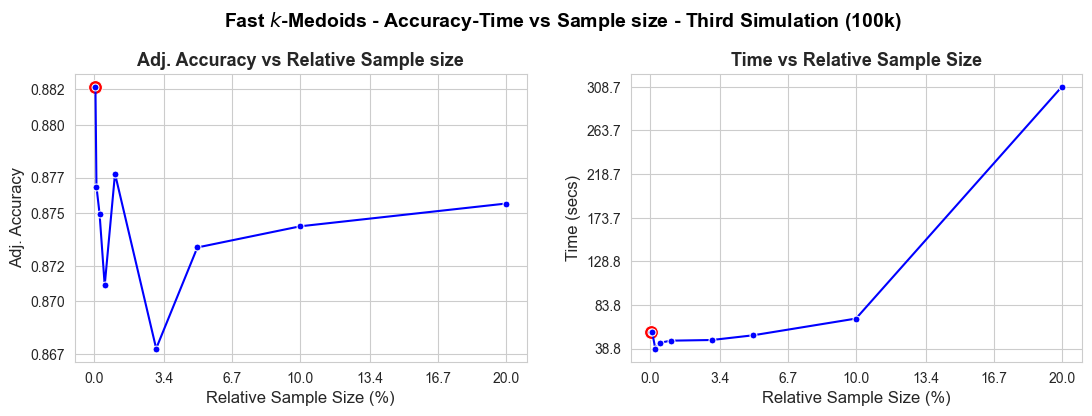

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(13,4))
axes = axes.flatten()  

sns.lineplot(x=[best_perc_size], y=[best_accuracy[best_frac_size]], color='red', marker='o',  markersize=10, ax=axes[0])
sns.lineplot(x=data_perc_sizes, y=best_accuracy_values, color='blue', marker='o',  markersize=5, ax=axes[0])

sns.lineplot(x=[best_perc_size], y=[times[best_frac_size]], color='red', marker='o', markersize=10, ax=axes[1])
sns.lineplot(x=data_perc_sizes, y=times_values, color='blue', marker='o', markersize=5, ax=axes[1])

axes[0].set_title('Adj. Accuracy vs Relative Sample size', size=13, weight='bold')
axes[0].set_ylabel('Adj. Accuracy', size=12)
axes[0].set_yticks(np.round(np.linspace(np.min(best_accuracy_values), np.max(best_accuracy_values), 7),3))

axes[1].set_title('Time vs Relative Sample Size', size=13, weight='bold')
axes[1].set_ylabel('Time (secs)', size=12)
axes[1].set_yticks(np.round(np.linspace(np.min(times_values), np.max(times_values), 7),1))

for i in range(len(axes)):
    axes[i].set_xticks(np.round(np.linspace(np.min(data_perc_sizes), np.max(data_perc_sizes), 7),1))
    axes[i].set_xlabel('Relative Sample Size (%)', size=12)


#plt.tight_layout()
plt.subplots_adjust(top=0.83)
plt.suptitle('Fast $k$-Medoids - Accuracy-Time vs Sample size - Third Simulation (100k)', fontsize=14, y=0.99, weight='bold', color='black', alpha=1)
plt.subplots_adjust(hspace=0.5, wspace=0.23) 

file_name = 'plots/kmedoids_simulation_3_acc_time'
fig.savefig(file_name + '.jpg', format='jpg', dpi=500)

plt.show()

In [17]:
print(f'Best size: {best_frac_size*len(X)}\nBest relative size: {best_perc_size}%\nBest accuracy: {np.round(best_accuracy[best_frac_size],4)}\nTime: {np.round(times[best_frac_size],2)} secs')

Best size: 50.0
Best relative size: 0.05%
Best accuracy: 0.8822
Time: 56.35 secs


## **Accuracy-Time vs Number of Folds -  KFold Fast Kmedoids**

In [8]:
n_splits = [5, 10, 20, 30, 40, 50, 60]
frac_sizes = [0.005, 0.001, 0.01, 0.02, 0.05, 0.1, 0.2]

In [ ]:
'''
kfold_fast_kmedoids_dict = {split: {} for split in n_splits}
times = {split: {} for split in n_splits}

for split in n_splits:
    print(split)
    for frac in frac_sizes:
        print(frac)
        try:
            model = KFoldFastKmedoidsGG(n_clusters=4, method='pam', init='heuristic', max_iter=100, 
                                        frac_sample_size=frac, random_state=123,
                                        n_splits=split, shuffle=True, kfold_random_state=111,
                                        p1=4, p2=2, p3=2, d1='robust_mahalanobis', d2='jaccard', d3='matching', 
                                        robust_maha_method='trimmed')
            start_time = time.time()
            model.fit(X=X_np) 
            end_time = time.time()
            kfold_fast_kmedoids_dict[split][frac] = model
            times[split][frac] = end_time - start_time
        except:
            print(f'Problems with split {split} and frac {frac}')

cluster_labels = {split: {frac: kfold_fast_kmedoids_dict[split][frac].labels for frac in kfold_fast_kmedoids_dict[split].keys()} for split in kfold_fast_kmedoids_dict.keys()}
'''

In [27]:
'''
with open(r'C:\Users\fscielzo\Documents\DataScience-GitHub\TFM\Clustering\results\cluster_labels_simu_3_Kfold.pkl', 'wb') as file:
    pickle.dump(cluster_labels, file)
with open(r'C:\Users\fscielzo\Documents\DataScience-GitHub\TFM\Clustering\results\times_simu_3_Kfold.pkl', 'wb') as file:
    pickle.dump(times, file)
'''

In [6]:
with open('results/cluster_labels_simu_3_Kfold.pkl', 'rb') as file:
    cluster_labels = pickle.load(file)
with open('results/times_simu_3_Kfold.pkl', 'rb') as file:
    times = pickle.load(file)

In [9]:
best_accuracy, best_cluster_labels = {split: {} for split in n_splits}, {split: {} for split in n_splits}
for split in cluster_labels.keys():
    for frac in cluster_labels[split].keys():
        best_accuracy[split][frac], best_cluster_labels[split][frac] = adjusted_accuracy(y_pred=cluster_labels[split][frac], y_true=Y)

In [10]:
best_frac = {}
for split in best_accuracy.keys():
    best_frac[split] = np.array(list(best_accuracy[split].keys()))[np.argmax(np.array(list(best_accuracy[split].values())))]
best_split = list(best_accuracy.keys())[np.argmax(np.array([best_accuracy[split][best_frac[split]] for split in best_accuracy.keys()]))]
n = len(X)
split_ratio = np.round((best_split/n)*100,3) # best_split = split_ratio * n

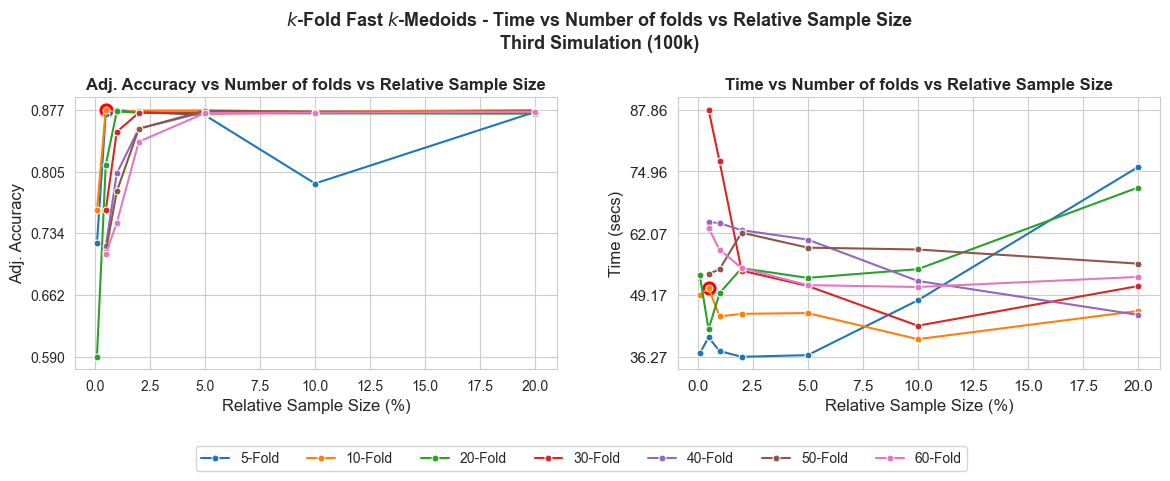

In [31]:
n_splits_values = np.array(list(times.keys()))
colors = sns.color_palette("tab10", len(n_splits_values))
min_acc_list, max_acc_list = [], []
min_time_list, max_time_list = [], []

fig, axes = plt.subplots(1, 2, figsize=(14,4))
axes = axes.flatten()

sns.lineplot(x=[best_frac[best_split]*100], y=[best_accuracy[best_split][best_frac[best_split]]], color='red', marker='o',  markersize=11, ax=axes[0])
for split, color in zip(n_splits_values, colors) :
    perc_size = np.array(list(best_accuracy[split].keys()))*100
    sns.lineplot(x=perc_size, y=best_accuracy[split].values(), color=color, marker='o',  markersize=5, label=f'{split}-Fold', ax=axes[0])
    min_acc_list.append(min(best_accuracy[split].values()))
    max_acc_list.append(max(best_accuracy[split].values()))

axes[0].set_ylabel('Adj. Accuracy', size=12)
min_y, max_y = min(min_acc_list), max(max_acc_list)
axes[0].set_yticks(np.round(np.linspace(min_y, max_y, 5),3)) 
axes[0].set_title('Adj. Accuracy vs Number of folds vs Relative Sample Size', size=12, weight='bold')

sns.lineplot(x=[best_frac[best_split]*100], y=[times[best_split][best_frac[best_split]]], color='red', marker='o',  markersize=11, ax=axes[1])
for split, color in zip(n_splits_values, colors) :
    perc_size = np.array(list(best_accuracy[split].keys()))*100
    sns.lineplot(x=perc_size, y=times[split].values(), color=color, marker='o',  markersize=5, label=f'{split}-Fold', ax=axes[1])
    min_time_list.append(min(times[split].values()))
    max_time_list.append(max(times[split].values()))

axes[1].set_ylabel('Time (secs)', size=12)
min_y, max_y = min(min_time_list), max(max_time_list)
axes[1].set_yticks(np.round(np.linspace(min_y, max_y, 5),3)) 
axes[1].set_title('Time vs Number of folds vs Relative Sample Size', size=12, weight='bold')

for i in range(len(axes)):
    axes[i].set_xlabel('Relative Sample Size (%)', size=12)
    axes[i].legend().set_visible(False)

plt.subplots_adjust(top=0.79)
plt.suptitle("$k$-Fold Fast $k$-Medoids - Time vs Number of folds vs Relative Sample Size\nThird Simulation (100k)", weight='bold', size=13, y=1.01)
plt.xticks(fontsize=11, rotation=0)
plt.yticks(fontsize=11)
plt.subplots_adjust(hspace=0.5, wspace=0.25) 

# Only create legend for the first subplot and hide the legend for the second subplot
handles, labels = axes[1].get_legend_handles_labels()
plt.legend(handles=handles, labels=labels, loc='lower center', bbox_to_anchor=(-0.2, -0.4), ncol=len(labels), fontsize=10)

file_name = 'plots/kfold_kmedoids_simulation_3_acc_time'
fig.savefig(file_name + '.jpg', format='jpg', dpi=500, bbox_inches="tight", pad_inches=0.2)
plt.show()

In [11]:
print(f'Best number of folds (splits): {best_split}\nBest percentage size: {best_frac[best_split]*100} %\nSplits ratio: {split_ratio} (best_split = split_ratio * n)\nTime: {np.round(times[best_split][best_frac[best_split]],2)} secs')

Best number of folds (splits): 10
Best percentage size: 0.5 %
Splits ratio: 0.01 (best_split = split_ratio * n)
Time: 50.63 secs


## **Comparison between clustering algorithms**

In [ ]:
'''
clara = CLARA(n_clusters=4, metric='euclidean')
start_time = time.time()
clara.fit(X)
end_time = time.time()
clara_time = end_time - start_time
clara_labels = clara.labels_
best_accuracy_clara, best_cluster_labels_clara = adjusted_accuracy(y_pred=clara_labels, y_true=Y)

diana = Diana(n_clusters=4)
start_time = time.time()
diana.fit(X_np)
end_time = time.time()
diana_labels = diana.labels_
diana_time = end_time - start_time
best_accuracy_diana, best_cluster_labels_diana = adjusted_accuracy(y_pred=diana_labels, y_true=Y)

ldakmeans = LDAKmeans(n_clusters=4)
start_time = time.time()
ldakmeans.fit(X_np)
end_time = time.time()
ldakmeans_labels = ldakmeans.labels_
ldakmeans_time = end_time - start_time
best_accuracy_ldakmeans, best_cluster_labels_ldakmeans = adjusted_accuracy(y_pred=ldakmeans_labels, y_true=Y)

subkmeans = SubKmeans(n_clusters=4)
start_time = time.time()
subkmeans.fit(X_np)
end_time = time.time()
subkmeans_labels = subkmeans.labels_
subkmeans_time = end_time - start_time
best_accuracy_subkmeans, best_cluster_labels_subkmeans = adjusted_accuracy(y_pred=subkmeans_labels, y_true=Y)

kmeans = KMeans(n_clusters=4, random_state=123, init='k-means++', n_init='auto', max_iter=300)
start_time = time.time()
kmeans.fit(X)
end_time = time.time()
kmeans_labels = kmeans.labels_
kmeans_time = end_time - start_time
best_accuracy_kmeans, best_cluster_labels_kmeans = adjusted_accuracy(y_pred=kmeans_labels, y_true=Y)

gmm = GaussianMixture(n_components=4, random_state=123)
start_time = time.time()
gmm.fit(X)
end_time = time.time()
gmm_labels = gmm.predict(X)
gmm_time = end_time - start_time
best_accuracy_gmm, best_cluster_labels_gmm = adjusted_accuracy(y_pred=gmm_labels, y_true=Y)

agg_clustering = AgglomerativeClustering(n_clusters=4)
start_time = time.time()
agg_clustering.fit(X)
end_time = time.time()
agg_labels = agg_clustering.labels_
agg_time = end_time - start_time
best_accuracy_agg, best_cluster_labels_agg = adjusted_accuracy(y_pred=agg_labels, y_true=Y)

spectral_bi = SpectralBiclustering(n_clusters=4)
start_time = time.time()
spectral_bi = spectral_bi.fit(X)
end_time = time.time()
spectral_bi_labels = spectral_bi.row_labels_
spectral_bi_time = end_time - start_time
best_accuracy_spectral_bi, best_cluster_labels_spectral_bi = adjusted_accuracy(y_pred=spectral_bi_labels, y_true=Y)

spectral_co = SpectralCoclustering(n_clusters=4)
start_time = time.time()
spectral_co = spectral_co.fit(X)
end_time = time.time()
spectral_co_labels = spectral_co.row_labels_
spectral_co_time = end_time - start_time
best_accuracy_spectral_co, best_cluster_labels_spectral_co = adjusted_accuracy(y_pred=spectral_co_labels, y_true=Y)

birch = Birch(n_clusters=4)
start_time = time.time()
birch = birch.fit(X)
end_time = time.time()
birch_labels = birch.labels_
birch_time = end_time - start_time
best_accuracy_birch, best_cluster_labels_birch = adjusted_accuracy(y_pred=birch_labels, y_true=Y)

bikmeans = BisectingKMeans(n_clusters=4, random_state=123, max_iter=300)
start_time = time.time()
bikmeans.fit(X)
end_time = time.time()
bikmeans_labels = bikmeans.labels_
bikmeans_time = end_time - start_time
best_accuracy_bikmeans, best_cluster_labels_bikmeans = adjusted_accuracy(y_pred=bikmeans_labels, y_true=Y)

batchkmeans = MiniBatchKMeans(n_clusters=4, random_state=123, max_iter=300)
start_time = time.time()
batchkmeans.fit(X)
end_time = time.time()
batchkmeans_labels = batchkmeans.labels_
batchkmeans_time = end_time - start_time
best_accuracy_batchkmeans, best_cluster_labels_batchkmeans = adjusted_accuracy(y_pred=batchkmeans_labels, y_true=Y)
'''

In [ ]:
'''
euclideanGG_fast_kmedoids = FastKmedoidsGG(n_clusters=4, method='pam', init='heuristic', max_iter=100, random_state=123,
                            frac_sample_size=best_frac_size, p1=4, p2=2, p3=2, d1='euclidean', d2='jaccard', d3='matching', 
                            VG_sample_size=1000, VG_n_samples=5)
start_time = time.time()
euclideanGG_fast_kmedoids.fit(X=X) 
end_time = time.time()
euclideanGG_fast_kmedoids_time = end_time - start_time
euclideanGG_fast_kmedoids_labels = euclideanGG_fast_kmedoids.labels
best_accuracy_euclideanGG_fast_kmedoids, best_cluster_labels_euclideanGG_fast_kmedoids = adjusted_accuracy(y_pred=euclideanGG_fast_kmedoids_labels, y_true=Y)

manhattanGG_fast_kmedoids = FastKmedoidsGG(n_clusters=4, method='pam', init='heuristic', max_iter=100, random_state=123,
                            frac_sample_size=best_frac_size, p1=4, p2=2, p3=2, d1='minkowski', d2='jaccard', d3='matching', q=1,
                            VG_sample_size=1000, VG_n_samples=5)
start_time = time.time()
manhattanGG_fast_kmedoids.fit(X=X) 
end_time = time.time()
manhattanGG_fast_kmedoids_time = end_time - start_time
manhattanGG_fast_kmedoids_labels = manhattanGG_fast_kmedoids.labels
best_accuracy_manhattanGG_fast_kmedoids, best_cluster_labels_manhattanGG_fast_kmedoids = adjusted_accuracy(y_pred=manhattanGG_fast_kmedoids_labels, y_true=Y)

mahaGG_fast_kmedoids = FastKmedoidsGG(n_clusters=4, method='pam', init='heuristic', max_iter=100, random_state=123,
                            frac_sample_size=best_frac_size, p1=4, p2=2, p3=2, d1='mahalanobis', d2='jaccard', d3='matching', q=1,
                            VG_sample_size=1000, VG_n_samples=5)
start_time = time.time()
mahaGG_fast_kmedoids.fit(X=X) 
end_time = time.time()
mahaGG_fast_kmedoids_time = end_time - start_time
mahaGG_fast_kmedoids_labels = mahaGG_fast_kmedoids.labels
best_accuracy_mahaGG_fast_kmedoids, best_cluster_labels_mahaGG_fast_kmedoids = adjusted_accuracy(y_pred=mahaGG_fast_kmedoids_labels, y_true=Y)

canberraGG_fast_kmedoids = FastKmedoidsGG(n_clusters=4, method='pam', init='heuristic', max_iter=100, random_state=123,
                            frac_sample_size=best_frac_size, p1=4, p2=2, p3=2, d1='canberra', d2='jaccard', d3='matching', q=1,
                            VG_sample_size=1000, VG_n_samples=5)
start_time = time.time()
canberraGG_fast_kmedoids.fit(X=X) 
end_time = time.time()
canberraGG_fast_kmedoids_time = end_time - start_time
canberraGG_fast_kmedoids_labels = canberraGG_fast_kmedoids.labels
best_accuracy_canberraGG_fast_kmedoids, best_cluster_labels_canberraGG_fast_kmedoids = adjusted_accuracy(y_pred=canberraGG_fast_kmedoids_labels, y_true=Y)

RMMADGG_fast_kmedoids = FastKmedoidsGG(n_clusters=4, method='pam', init='heuristic', max_iter=100, random_state=123,
                            frac_sample_size=best_frac_size, p1=4, p2=2, p3=2, d1='robust_mahalanobis', d2='jaccard', d3='matching', 
                            robust_maha_method='MAD', alpha=0.05, epsilon=0.05, n_iters=20,
                            VG_sample_size=1000, VG_n_samples=5)
start_time = time.time()
RMMADGG_fast_kmedoids.fit(X=X) 
end_time = time.time()
RMMADGG_fast_kmedoids_time = end_time - start_time
RMMADGG_fast_kmedoids_labels = RMMADGG_fast_kmedoids.labels
best_accuracy_RMMADGG_fast_kmedoids, best_cluster_labels_RMMADGG_fast_kmedoids = adjusted_accuracy(y_pred=RMMADGG_fast_kmedoids_labels, y_true=Y)

RMMADSokalGG_fast_kmedoids = FastKmedoidsGG(n_clusters=4, method='pam', init='heuristic', max_iter=100, random_state=123,
                            frac_sample_size=best_frac_size, p1=4, p2=2, p3=2, d1='robust_mahalanobis', d2='sokal', d3='matching', 
                            robust_maha_method='MAD', alpha=0.05, epsilon=0.05, n_iters=20,
                            VG_sample_size=1000, VG_n_samples=5)
start_time = time.time()
RMMADSokalGG_fast_kmedoids.fit(X=X) 
end_time = time.time()
RMMADSokalGG_fast_kmedoids_time = end_time - start_time
RMMADSokalGG_fast_kmedoids_labels = RMMADSokalGG_fast_kmedoids.labels
best_accuracy_RMMADSokalGG_fast_kmedoids, best_cluster_labels_RMMADSokalGG_fast_kmedoids = adjusted_accuracy(y_pred=RMMADSokalGG_fast_kmedoids_labels, y_true=Y)

RMwinSokalGG_fast_kmedoids = FastKmedoidsGG(n_clusters=4, method='pam', init='heuristic', max_iter=100, random_state=123,
                            frac_sample_size=best_frac_size, p1=4, p2=2, p3=2, d1='robust_mahalanobis', d2='sokal', d3='matching', 
                            robust_maha_method='winsorized', alpha=0.05, epsilon=0.05, n_iters=20,
                            VG_sample_size=1000, VG_n_samples=5)
start_time = time.time()
RMwinSokalGG_fast_kmedoids.fit(X=X) 
end_time = time.time()
RMwinSokalGG_fast_kmedoids_time = end_time - start_time
RMwinSokalGG_fast_kmedoids_labels = RMwinSokalGG_fast_kmedoids.labels
best_accuracy_RMwinSokalGG_fast_kmedoids, best_cluster_labels_RMwinSokalGG_fast_kmedoids = adjusted_accuracy(y_pred=RMwinSokalGG_fast_kmedoids_labels, y_true=Y)

RMwinGG_fast_kmedoids = FastKmedoidsGG(n_clusters=4, method='pam', init='heuristic', max_iter=100, random_state=123,
                            frac_sample_size=best_frac_size, p1=4, p2=2, p3=2, d1='robust_mahalanobis', d2='jaccard', d3='matching', 
                            robust_maha_method='winsorized', alpha=0.05, epsilon=0.05, n_iters=20,
                            VG_sample_size=1000, VG_n_samples=5)
start_time = time.time()
RMwinGG_fast_kmedoids.fit(X=X) 
end_time = time.time()
RMwinGG_fast_kmedoids_time = end_time - start_time
RMwinGG_fast_kmedoids_labels = RMwinGG_fast_kmedoids.labels
best_accuracy_RMwinGG_fast_kmedoids, best_cluster_labels_RMwinGG_fast_kmedoids = adjusted_accuracy(y_pred=RMwinGG_fast_kmedoids_labels, y_true=Y)

RMtrimSokalGG_fast_kmedoids = FastKmedoidsGG(n_clusters=4, method='pam', init='heuristic', max_iter=100, random_state=123,
                            frac_sample_size=best_frac_size, p1=4, p2=2, p3=2, d1='robust_mahalanobis', d2='sokal', d3='matching', 
                            robust_maha_method='trimmed', alpha=0.05, epsilon=0.05, n_iters=20,
                            VG_sample_size=1000, VG_n_samples=5)
start_time = time.time()
RMtrimSokalGG_fast_kmedoids.fit(X=X) 
end_time = time.time()
RMtrimSokalGG_fast_kmedoids_time = end_time - start_time
RMtrimSokalGG_fast_kmedoids_labels = RMtrimSokalGG_fast_kmedoids.labels
best_accuracy_RMtrimSokalGG_fast_kmedoids, best_cluster_labels_RMtrimSokalGG_fast_kmedoids = adjusted_accuracy(y_pred=RMtrimSokalGG_fast_kmedoids_labels, y_true=Y)

RMtrimJaccardGG_fast_kmedoids = FastKmedoidsGG(n_clusters=4, method='pam', init='heuristic', max_iter=100, random_state=123,
                            frac_sample_size=best_frac_size, p1=4, p2=2, p3=2, d1='robust_mahalanobis', d2='jaccard', d3='matching', 
                            robust_maha_method='trimmed', alpha=0.05, epsilon=0.05, n_iters=20,
                            VG_sample_size=1000, VG_n_samples=5)
start_time = time.time()
RMtrimJaccardGG_fast_kmedoids.fit(X=X) 
end_time = time.time()
RMtrimJaccardGG_fast_kmedoids_time = end_time - start_time
RMtrimJaccardGG_fast_kmedoids_labels = RMtrimJaccardGG_fast_kmedoids.labels
best_accuracy_RMtrimJaccardGG_fast_kmedoids, best_cluster_labels_RMtrimJaccardGG_fast_kmedoids = adjusted_accuracy(y_pred=RMtrimJaccardGG_fast_kmedoids_labels, y_true=Y)
'''

In [ ]:
'''
model = KFoldFastKmedoidsGG(n_clusters=4, method='pam', init='heuristic', max_iter=100, random_state=123,
                                n_splits=best_split, shuffle=True, frac_sample_size=best_frac[best_split], 
                                p1=4, p2=2, p3=2, d1='minkowski', d2='jaccard', d3='matching', q=1)
start_time = time.time()
model.fit(X=X_np) 
end_time = time.time()
manhattanGG_kfold_fast_kmedoids_time = end_time - start_time
manhattanGG_kfold_fast_kmedoids_labels = model.labels
best_accuracy_manhattanGG_kfold_fast_kmedoids, best_cluster_labels_manhattanGG_kfold_fast_kmedoids = adjusted_accuracy(y_pred=manhattanGG_kfold_fast_kmedoids_labels, y_true=Y)


model = KFoldFastKmedoidsGG(n_clusters=4, method='pam', init='heuristic', max_iter=100, random_state=123,
                                n_splits=best_split, shuffle=True, frac_sample_size=best_frac[best_split], kfold_random_state=123, 
                                p1=4, p2=2, p3=2, d1='euclidean', d2='jaccard', d3='matching')
start_time = time.time()
model.fit(X=X_np) 
end_time = time.time()
euclideanGG_kfold_fast_kmedoids_time = end_time - start_time
euclideanGG_kfold_fast_kmedoids_labels = model.labels
best_accuracy_euclideanGG_kfold_fast_kmedoids, best_cluster_labels_euclideanGG_kfold_fast_kmedoids = adjusted_accuracy(y_pred=euclideanGG_kfold_fast_kmedoids_labels, y_true=Y)


model = KFoldFastKmedoidsGG(n_clusters=4, method='pam', init='heuristic', max_iter=100, random_state=123,
                                n_splits=best_split, shuffle=True, frac_sample_size=best_frac[best_split], kfold_random_state=111, 
                                p1=4, p2=2, p3=2, d1='canberra', d2='jaccard', d3='matching')
start_time = time.time()
model.fit(X=X_np) 
end_time = time.time()
canberraGG_kfold_fast_kmedoids_time = end_time - start_time
canberraGG_kfold_fast_kmedoids_labels = model.labels
best_accuracy_canberraGG_kfold_fast_kmedoids, best_cluster_labels_canberraGG_kfold_fast_kmedoids = adjusted_accuracy(y_pred=canberraGG_kfold_fast_kmedoids_labels, y_true=Y)


model = KFoldFastKmedoidsGG(n_clusters=4, method='pam', init='heuristic', max_iter=100, random_state=123,
                                n_splits=best_split, shuffle=True, frac_sample_size=best_frac[best_split], 
                                p1=4, p2=2, p3=2, d1='mahalanobis', d2='jaccard', d3='matching')
start_time = time.time()
model.fit(X=X_np) 
end_time = time.time()
mahalanobisGG_kfold_fast_kmedoids_time = end_time - start_time
mahalanobisGG_kfold_fast_kmedoids_labels = model.labels
best_accuracy_mahalanobisGG_kfold_fast_kmedoids, best_cluster_labels_mahalanobisGG_kfold_fast_kmedoids = adjusted_accuracy(y_pred=mahalanobisGG_kfold_fast_kmedoids_labels, y_true=Y)


model = KFoldFastKmedoidsGG(n_clusters=4, method='pam', init='heuristic', max_iter=100, random_state=123,
                            n_splits=best_split, frac_sample_size=best_frac[best_split], shuffle=True, kfold_random_state=111,
                            p1=4, p2=2, p3=2, d1='robust_mahalanobis', d2='jaccard', d3='matching', 
                            robust_maha_method='MAD', alpha=0.05, epsilon=0.05, n_iters=20
                            )
start_time = time.time()
model.fit(X=X_np) 
end_time = time.time()
RMMADGG_kfold_fast_kmedoids_time = end_time - start_time
RMMADGG_kfold_fast_kmedoids_labels = model.labels
best_accuracy_RMMADGG_kfold_fast_kmedoids, best_cluster_labels_RMMADGG_kfold_fast_kmedoids = adjusted_accuracy(y_pred=RMMADGG_kfold_fast_kmedoids_labels, y_true=Y)


RMMADSokalGG_kfold_fast_kmedoids = KFoldFastKmedoidsGG(n_clusters=4, method='pam', init='heuristic', max_iter=100, random_state=123,
                            n_splits=best_split, frac_sample_size=best_frac[best_split], shuffle=True, kfold_random_state=111,
                            p1=4, p2=2, p3=2, d1='robust_mahalanobis', d2='sokal', d3='matching', 
                            robust_maha_method='MAD', alpha=0.05, epsilon=0.05, n_iters=20
                            )
start_time = time.time()
RMMADSokalGG_kfold_fast_kmedoids.fit(X=X_np) 
end_time = time.time()
RMMADSokalGG_kfold_fast_kmedoids_time = end_time - start_time
RMMADSokalGG_kfold_fast_kmedoids_labels = RMMADSokalGG_kfold_fast_kmedoids.labels
best_accuracy_RMMADSokalGG_kfold_fast_kmedoids, best_cluster_labels_RMMADSokalGG_kfold_fast_kmedoids = adjusted_accuracy(y_pred=RMMADSokalGG_kfold_fast_kmedoids_labels, y_true=Y)


RMwinSokalGG_kfold_fast_kmedoids = KFoldFastKmedoidsGG(n_clusters=4, method='pam', init='heuristic', max_iter=100, random_state=123,
                             n_splits=best_split, frac_sample_size=best_frac[best_split], shuffle=True, kfold_random_state=111,
                             p1=4, p2=2, p3=2, d1='robust_mahalanobis', d2='sokal', d3='matching', 
                             robust_maha_method='winsorized', alpha=0.05, epsilon=0.05, n_iters=20
                            )
start_time = time.time()
RMwinSokalGG_kfold_fast_kmedoids.fit(X=X_np) 
end_time = time.time()
RMwinSokalGG_kfold_fast_kmedoids_time = end_time - start_time
RMwinSokalGG_kfold_fast_kmedoids_labels = RMwinSokalGG_kfold_fast_kmedoids.labels
best_accuracy_RMwinSokalGG_kfold_fast_kmedoids, best_cluster_labels_RMwinSokalGG_kfold_fast_kmedoids = adjusted_accuracy(y_pred=RMwinSokalGG_kfold_fast_kmedoids_labels, y_true=Y)


RMwinGG_kfold_fast_kmedoids = KFoldFastKmedoidsGG(n_clusters=4, method='pam', init='heuristic', max_iter=100, random_state=123,
                             n_splits=best_split, frac_sample_size=best_frac[best_split], shuffle=True, kfold_random_state=111,
                             p1=4, p2=2, p3=2, d1='robust_mahalanobis', d2='jaccard', d3='matching', 
                            robust_maha_method='winsorized', alpha=0.05, epsilon=0.05, n_iters=20,
                            VG_sample_size=1000, VG_n_samples=5)
start_time = time.time()
RMwinGG_kfold_fast_kmedoids.fit(X=X_np) 
end_time = time.time()
RMwinGG_kfold_fast_kmedoids_time = end_time - start_time
RMwinGG_kfold_fast_kmedoids_labels = RMwinGG_kfold_fast_kmedoids.labels
best_accuracy_RMwinGG_kfold_fast_kmedoids, best_cluster_labels_RMwinGG_kfold_fast_kmedoids = adjusted_accuracy(y_pred=RMwinGG_kfold_fast_kmedoids_labels, y_true=Y)


RMtrimSokalGG_kfold_fast_kmedoids = KFoldFastKmedoidsGG(n_clusters=4, method='pam', init='heuristic', max_iter=100, random_state=123,
                            n_splits=best_split, frac_sample_size=best_frac[best_split], shuffle=True, kfold_random_state=111,
                            p1=4, p2=2, p3=2, d1='robust_mahalanobis', d2='sokal', d3='matching', 
                            robust_maha_method='trimmed', alpha=0.05, epsilon=0.05, n_iters=20,
                            VG_sample_size=1000, VG_n_samples=5)
start_time = time.time()
RMtrimSokalGG_kfold_fast_kmedoids.fit(X=X_np) 
end_time = time.time()
RMtrimSokalGG_kfold_fast_kmedoids_time = end_time - start_time
RMtrimSokalGG_kfold_fast_kmedoids_labels = RMtrimSokalGG_kfold_fast_kmedoids.labels
best_accuracy_RMtrimSokalGG_kfold_fast_kmedoids, best_cluster_labels_RMtrimSokalGG_kfold_fast_kmedoids = adjusted_accuracy(y_pred=RMtrimSokalGG_kfold_fast_kmedoids_labels, y_true=Y)

RMtrimJaccardGG_kfold_fast_kmedoids = KFoldFastKmedoidsGG(n_clusters=4, method='pam', init='heuristic', max_iter=100, random_state=123,
                            n_splits=best_split, frac_sample_size=best_frac[best_split], shuffle=True, kfold_random_state=111,
                            p1=4, p2=2, p3=2, d1='robust_mahalanobis', d2='jaccard', d3='matching', 
                            robust_maha_method='trimmed', alpha=0.05, epsilon=0.05, n_iters=20,
                            VG_sample_size=1000, VG_n_samples=5)
start_time = time.time()
RMtrimJaccardGG_kfold_fast_kmedoids.fit(X=X_np) 
end_time = time.time()
RMtrimJaccardGG_kfold_fast_kmedoids_time = end_time - start_time
RMtrimJaccardGG_kfold_fast_kmedoids_labels = RMtrimJaccardGG_kfold_fast_kmedoids.labels
best_accuracy_RMtrimJaccardGG_kfold_fast_kmedoids, best_cluster_labels_RMtrimJaccardGG_kfold_fast_kmedoids = adjusted_accuracy(y_pred=RMtrimJaccardGG_kfold_fast_kmedoids_labels, y_true=Y)
'''

In [ ]:
'''
cluster_labels, accuracy_cluster, time_cluster = {}, {}, {}

cluster_labels['CLARA'] = best_cluster_labels_clara
accuracy_cluster['CLARA'] = best_accuracy_clara
time_cluster['CLARA'] = clara_time

cluster_labels['Kmeans'] = best_cluster_labels_kmeans
accuracy_cluster['Kmeans'] = best_accuracy_kmeans
time_cluster['Kmeans'] = kmeans_time

cluster_labels['agglomerative'] = agg_labels
accuracy_cluster['agglomerative'] = best_accuracy_agg
time_cluster['agglomerative'] = agg_time

cluster_labels['Spectral-BiClustering'] = best_cluster_labels_spectral_bi
accuracy_cluster['Spectral-BiClustering'] = best_accuracy_spectral_bi
time_cluster['Spectral-BiClustering'] = spectral_bi_time

cluster_labels['Spectral-CoClustering'] = best_cluster_labels_spectral_bi
accuracy_cluster['Spectral-CoClustering'] = best_accuracy_spectral_co
time_cluster['Spectral-CoClustering'] = spectral_co_time

cluster_labels['Birch'] = best_cluster_labels_birch
accuracy_cluster['Birch'] = best_accuracy_birch
time_cluster['Birch'] = birch_time

cluster_labels['Bisecting KMeans'] = best_cluster_labels_bikmeans
accuracy_cluster['Bisecting KMeans'] = best_accuracy_bikmeans
time_cluster['Bisecting KMeans'] = bikmeans_time

cluster_labels['MiniBatch Kmeans'] = best_cluster_labels_batchkmeans
accuracy_cluster['MiniBatch Kmeans'] = best_accuracy_batchkmeans
time_cluster['MiniBatch Kmeans'] = batchkmeans_time

cluster_labels['Euclidean Kmedoids'] = best_cluster_labels_euclidean_kmedoids
accuracy_cluster['Euclidean Kmedoids'] = best_accuracy_euclidean_kmedoids
time_cluster['Euclidean Kmedoids'] = euclidean_kmedoids_time

cluster_labels['SubKmeans'] = best_cluster_labels_subkmeans
accuracy_cluster['SubKmeans'] = best_accuracy_subkmeans
time_cluster['SubKmeans'] = subkmeans_time

cluster_labels['LDAKmeans'] = best_cluster_labels_ldakmeans
accuracy_cluster['LDAKmeans'] = best_accuracy_ldakmeans
time_cluster['LDAKmeans'] = ldakmeans_time

cluster_labels['Diana'] = best_cluster_labels_diana
accuracy_cluster['Diana'] = best_accuracy_diana
time_cluster['Diana'] = diana_time

cluster_labels['GMM'] = best_cluster_labels_gmm
accuracy_cluster['GMM'] = best_accuracy_gmm
time_cluster['GMM'] = gmm_time

adj_rand_index = {x: adjusted_rand_score(labels_pred=cluster_labels[x], labels_true=Y) for x in cluster_labels.keys()}
'''

In [38]:
'''
cluster_labels['Euclidean-Jaccard-GG Fast-Kmedoids'] = best_cluster_labels_euclideanGG_fast_kmedoids
accuracy_cluster['Euclidean-Jaccard-GG Fast-Kmedoids'] = best_accuracy_euclideanGG_fast_kmedoids
time_cluster['Euclidean-Jaccard-GG Fast-Kmedoids'] = euclideanGG_fast_kmedoids_time

cluster_labels['Manhattan-Jaccard-GG Fast-Kmedoids'] = best_cluster_labels_manhattanGG_fast_kmedoids
accuracy_cluster['Manhattan-Jaccard-GG Fast-Kmedoids'] = best_accuracy_manhattanGG_fast_kmedoids
time_cluster['Manhattan-Jaccard-GG Fast-Kmedoids'] = manhattanGG_fast_kmedoids_time

cluster_labels['Maha-Jaccard-GG Fast-Kmedoids'] = best_cluster_labels_mahaGG_fast_kmedoids
accuracy_cluster['Maha-Jaccard-GG Fast-Kmedoids'] = best_accuracy_mahaGG_fast_kmedoids
time_cluster['Maha-Jaccard-GG Fast-Kmedoids'] = mahaGG_fast_kmedoids_time

cluster_labels['Canberra-Jaccard-GG Fast-Kmedoids'] = best_cluster_labels_canberraGG_fast_kmedoids
accuracy_cluster['Canberra-Jaccard-GG Fast-Kmedoids'] = best_accuracy_canberraGG_fast_kmedoids
time_cluster['Canberra-Jaccard-GG Fast-Kmedoids'] = canberraGG_fast_kmedoids_time

cluster_labels['Robust-Maha-Trim-Sokal-GG Fast-Kmedoids'] = best_cluster_labels_RMtrimSokalGG_fast_kmedoids
accuracy_cluster['Robust-Maha-Trim-Sokal-GG Fast-Kmedoids'] = best_accuracy_RMtrimSokalGG_fast_kmedoids
time_cluster['Robust-Maha-Trim-Sokal-GG Fast-Kmedoids'] = RMtrimSokalGG_fast_kmedoids_time

cluster_labels['Robust-Maha-Trim-Jaccard-GG Fast-Kmedoids'] = best_cluster_labels_RMtrimJaccardGG_fast_kmedoids
accuracy_cluster['Robust-Maha-Trim-Jaccard-GG Fast-Kmedoids'] = best_accuracy_RMtrimJaccardGG_fast_kmedoids
time_cluster['Robust-Maha-Trim-Jaccard-GG Fast-Kmedoids'] = RMtrimJaccardGG_fast_kmedoids_time

cluster_labels['Robust-Maha-MAD-Sokal-GG Fast-Kmedoids'] = best_cluster_labels_RMMADSokalGG_fast_kmedoids
accuracy_cluster['Robust-Maha-MAD-Sokal-GG Fast-Kmedoids'] = best_accuracy_RMMADSokalGG_fast_kmedoids
time_cluster['Robust-Maha-MAD-Sokal-GG Fast-Kmedoids'] = RMMADSokalGG_fast_kmedoids_time

cluster_labels['Robust-Maha-Win-Sokal-GG Fast-Kmedoids'] = best_cluster_labels_RMwinSokalGG_fast_kmedoids
accuracy_cluster['Robust-Maha-Win-Sokal-GG Fast-Kmedoids'] = best_accuracy_RMwinSokalGG_fast_kmedoids
time_cluster['Robust-Maha-Win-Sokal-GG Fast-Kmedoids'] = RMwinSokalGG_fast_kmedoids_time

cluster_labels['Robust-Maha-MAD-Jaccard-GG Fast-Kmedoids'] = best_cluster_labels_RMMADGG_fast_kmedoids
accuracy_cluster['Robust-Maha-MAD-Jaccard-GG Fast-Kmedoids'] = best_accuracy_RMMADGG_fast_kmedoids
time_cluster['Robust-Maha-MAD-Jaccard-GG Fast-Kmedoids'] = RMMADGG_fast_kmedoids_time

cluster_labels['Robust-Maha-Win-Jaccard-GG Fast-Kmedoids'] = best_cluster_labels_RMwinGG_fast_kmedoids
accuracy_cluster['Robust-Maha-Win-Jaccard-GG Fast-Kmedoids'] = best_accuracy_RMwinGG_fast_kmedoids
time_cluster['Robust-Maha-Win-Jaccard-GG Fast-Kmedoids'] = RMwinGG_fast_kmedoids_time
'''

In [39]:
'''
cluster_labels['Euclidean-Jaccard-GG KFold-Fast-Kmedoids'] = best_cluster_labels_euclideanGG_kfold_fast_kmedoids
accuracy_cluster['Euclidean-Jaccard-GG KFold-Fast-Kmedoids'] = best_accuracy_euclideanGG_kfold_fast_kmedoids
time_cluster['Euclidean-Jaccard-GG KFold-Fast-Kmedoids'] = euclideanGG_kfold_fast_kmedoids_time

cluster_labels['Manhattan-Jaccard-GG KFold-Fast-Kmedoids'] = best_cluster_labels_manhattanGG_kfold_fast_kmedoids
accuracy_cluster['Manhattan-Jaccard-GG KFold-Fast-Kmedoids'] = best_accuracy_manhattanGG_kfold_fast_kmedoids
time_cluster['Manhattan-Jaccard-GG KFold-Fast-Kmedoids'] = manhattanGG_kfold_fast_kmedoids_time

cluster_labels['Maha-Jaccard-GG KFold-Fast-Kmedoids'] = best_cluster_labels_mahalanobisGG_kfold_fast_kmedoids
accuracy_cluster['Maha-Jaccard-GG KFold-Fast-Kmedoids'] = best_accuracy_mahalanobisGG_kfold_fast_kmedoids
time_cluster['Maha-Jaccard-GG KFold-Fast-Kmedoids'] = mahalanobisGG_kfold_fast_kmedoids_time

cluster_labels['Canberra-Jaccard-GG KFold-Fast-Kmedoids'] = best_cluster_labels_canberraGG_kfold_fast_kmedoids
accuracy_cluster['Canberra-Jaccard-GG KFold-Fast-Kmedoids'] = best_accuracy_canberraGG_kfold_fast_kmedoids
time_cluster['Canberra-Jaccard-GG KFold-Fast-Kmedoids'] = canberraGG_kfold_fast_kmedoids_time

cluster_labels['Robust-Maha-Trim-Sokal-GG KFold-Fast-Kmedoids'] = best_cluster_labels_RMtrimSokalGG_kfold_fast_kmedoids
accuracy_cluster['Robust-Maha-Trim-Sokal-GG KFold-Fast-Kmedoids'] = best_accuracy_RMtrimSokalGG_kfold_fast_kmedoids
time_cluster['Robust-Maha-Trim-Sokal-GG KFold-Fast-Kmedoids'] = RMtrimSokalGG_kfold_fast_kmedoids_time

cluster_labels['Robust-Maha-MAD-Sokal-GG KFold-Fast-Kmedoids'] = best_cluster_labels_RMMADSokalGG_kfold_fast_kmedoids
accuracy_cluster['Robust-Maha-MAD-Sokal-GG KFold-Fast-Kmedoids'] = best_accuracy_RMMADSokalGG_kfold_fast_kmedoids
time_cluster['Robust-Maha-MAD-Sokal-GG KFold-Fast-Kmedoids'] = RMMADSokalGG_kfold_fast_kmedoids_time

cluster_labels['Robust-Maha-Win-Sokal-GG KFold-Fast-Kmedoids'] = best_cluster_labels_RMwinSokalGG_kfold_fast_kmedoids
accuracy_cluster['Robust-Maha-Win-Sokal-GG KFold-Fast-Kmedoids'] = best_accuracy_RMwinSokalGG_kfold_fast_kmedoids
time_cluster['Robust-Maha-Win-Sokal-GG KFold-Fast-Kmedoids'] = RMwinSokalGG_kfold_fast_kmedoids_time

cluster_labels['Robust-Maha-MAD-Jaccard-GG KFold-Fast-Kmedoids'] = best_cluster_labels_RMMADGG_kfold_fast_kmedoids
accuracy_cluster['Robust-Maha-MAD-Jaccard-GG KFold-Fast-Kmedoids'] = best_accuracy_RMMADGG_kfold_fast_kmedoids
time_cluster['Robust-Maha-MAD-Jaccard-GG KFold-Fast-Kmedoids'] = RMMADGG_kfold_fast_kmedoids_time

cluster_labels['Robust-Maha-Win-Jaccard-GG KFold-Fast-Kmedoids'] = best_cluster_labels_RMwinGG_kfold_fast_kmedoids
accuracy_cluster['Robust-Maha-Win-Jaccard-GG KFold-Fast-Kmedoids'] = best_accuracy_RMwinGG_kfold_fast_kmedoids
time_cluster['Robust-Maha-Win-Jaccard-GG KFold-Fast-Kmedoids'] = RMwinGG_kfold_fast_kmedoids_time

cluster_labels['Robust-Maha-Trim-Jaccard-GG KFold-Fast-Kmedoids'] = best_cluster_labels[best_split][best_frac[best_split]]
accuracy_cluster['Robust-Maha-Trim-Jaccard-GG KFold-Fast-Kmedoids'] = best_accuracy[best_split][best_frac[best_split]]
time_cluster['Robust-Maha-Trim-Jaccard-GG KFold-Fast-Kmedoids'] = times[best_split][best_frac[best_split]]

adj_rand_index = {x: adjusted_rand_score(labels_pred=cluster_labels[x], labels_true=Y) for x in cluster_labels.keys()}
'''

In [42]:
'''
with open('results/comparison_cluster_labels_simu_3.pkl', 'wb') as file:
    pickle.dump(cluster_labels, file)
with open('results/comparison_times_simu_3.pkl', 'wb') as file:
    pickle.dump(time_cluster, file)
with open('results/comparison_accuracy_simu_3.pkl', 'wb') as file:
    pickle.dump(accuracy_cluster, file)
with open('results/comparison_rand_index_simu_3.pkl', 'wb') as file:
    pickle.dump(adj_rand_index, file)
'''

In [5]:
with open('results/comparison_cluster_labels_simu_3.pkl', 'rb') as file:
    cluster_labels = pickle.load(file)
with open('results/comparison_times_simu_3.pkl', 'rb') as file:
    time_cluster = pickle.load(file)
with open('results/comparison_accuracy_simu_3.pkl', 'rb') as file:
    accuracy_cluster = pickle.load(file)
with open('results/comparison_rand_index_simu_3.pkl', 'rb') as file:
    adj_rand_index = pickle.load(file)

In [6]:
time_cluster

{'CLARA': 0.07522082328796387,
 'Kmeans': 0.1821451187133789,
 'Spectral-BiClustering': 3.8826019763946533,
 'Spectral-CoClustering': 0.4330112934112549,
 'Bisecting KMeans': 0.09604215621948242,
 'MiniBatch Kmeans': 0.09761333465576172,
 'Euclidean-Jaccard-GG Fast-Kmedoids': 7.652029275894165,
 'Manhattan-Jaccard-GG Fast-Kmedoids': 9.471153497695923,
 'Maha-Jaccard-GG Fast-Kmedoids': 8.669578790664673,
 'Canberra-Jaccard-GG Fast-Kmedoids': 11.546064138412476,
 'Robust-Maha-Trim-Sokal-GG Fast-Kmedoids': 45.87191438674927,
 'Robust-Maha-MAD-Sokal-GG Fast-Kmedoids': 46.665536403656006,
 'Robust-Maha-Win-Sokal-GG Fast-Kmedoids': 46.83067989349365,
 'Robust-Maha-MAD-Jaccard-GG Fast-Kmedoids': 41.597675800323486,
 'Robust-Maha-Win-Jaccard-GG Fast-Kmedoids': 40.86251354217529,
 'Robust-Maha-Trim-Jaccard-GG Fast-Kmedoids': 43.53689217567444,
 'GMM': 0.517871618270874,
 'Euclidean-Jaccard-GG KFold-Fast-Kmedoids': 10.78519606590271,
 'Manhattan-Jaccard-GG KFold-Fast-Kmedoids': 10.10422635078430

In [6]:
not_feasible_methods = ['Diana', 'DipInit', 'Agglomerative', 'Spectral-Clustering', 'Birch', 'Euclidean Kmedoids']
for method in not_feasible_methods:
    cluster_labels[method] = None
    accuracy_cluster[method] = 0
    adj_rand_index[method] = 0
    time_cluster[method] = 0
    
clustering_methods = list(cluster_labels.keys())
accuracy_list = np.array(list(accuracy_cluster.values()))
adj_rand_index_list = np.array(list(adj_rand_index.values()))
time_list = np.array(list(time_cluster.values()))

best_clustering_method = clustering_methods[np.argmax(accuracy_list)]
accuracy_best_method = np.max(accuracy_list)

combined_methods_accuracy = list(zip(clustering_methods, accuracy_list))
sorted_combined_methods_accuracy = sorted(combined_methods_accuracy, key=lambda x: x[1], reverse=True)  # Sort from greater to lower
sorted_methods_accuracy, sorted_accuracies = zip(*sorted_combined_methods_accuracy)

our_methods_1 = [x for x in clustering_methods if 'Fast' in x and 'KFold' not in x] # Fast Kmedoids
our_methods_2 = [x for x in clustering_methods if 'Fast' in x and 'KFold' in x] # KFold Fast Kmedoids
other_methods = [x for x in clustering_methods if x not in our_methods_1 + our_methods_2 and x not in not_feasible_methods]

In [7]:
sorted_combined_methods_accuracy

[('Robust-Maha-Trim-Sokal-GG Fast-Kmedoids', 0.92252),
 ('Robust-Maha-Win-Sokal-GG KFold-Fast-Kmedoids', 0.91999),
 ('Robust-Maha-Win-Sokal-GG Fast-Kmedoids', 0.91958),
 ('Robust-Maha-Trim-Sokal-GG KFold-Fast-Kmedoids', 0.91843),
 ('Robust-Maha-MAD-Sokal-GG Fast-Kmedoids', 0.91813),
 ('Robust-Maha-MAD-Sokal-GG KFold-Fast-Kmedoids', 0.91385),
 ('Canberra-Jaccard-GG KFold-Fast-Kmedoids', 0.91308),
 ('Canberra-Jaccard-GG Fast-Kmedoids', 0.91236),
 ('Euclidean-Jaccard-GG KFold-Fast-Kmedoids', 0.89525),
 ('Manhattan-Jaccard-GG KFold-Fast-Kmedoids', 0.89276),
 ('Manhattan-Jaccard-GG Fast-Kmedoids', 0.8875),
 ('Robust-Maha-Trim-Jaccard-GG Fast-Kmedoids', 0.88215),
 ('Euclidean-Jaccard-GG Fast-Kmedoids', 0.87868),
 ('Robust-Maha-Win-Jaccard-GG Fast-Kmedoids', 0.87766),
 ('Robust-Maha-Trim-Jaccard-GG KFold-Fast-Kmedoids', 0.87707),
 ('Robust-Maha-Win-Jaccard-GG KFold-Fast-Kmedoids', 0.87645),
 ('Robust-Maha-MAD-Jaccard-GG Fast-Kmedoids', 0.87192),
 ('Robust-Maha-MAD-Jaccard-GG KFold-Fast-Kmedoi

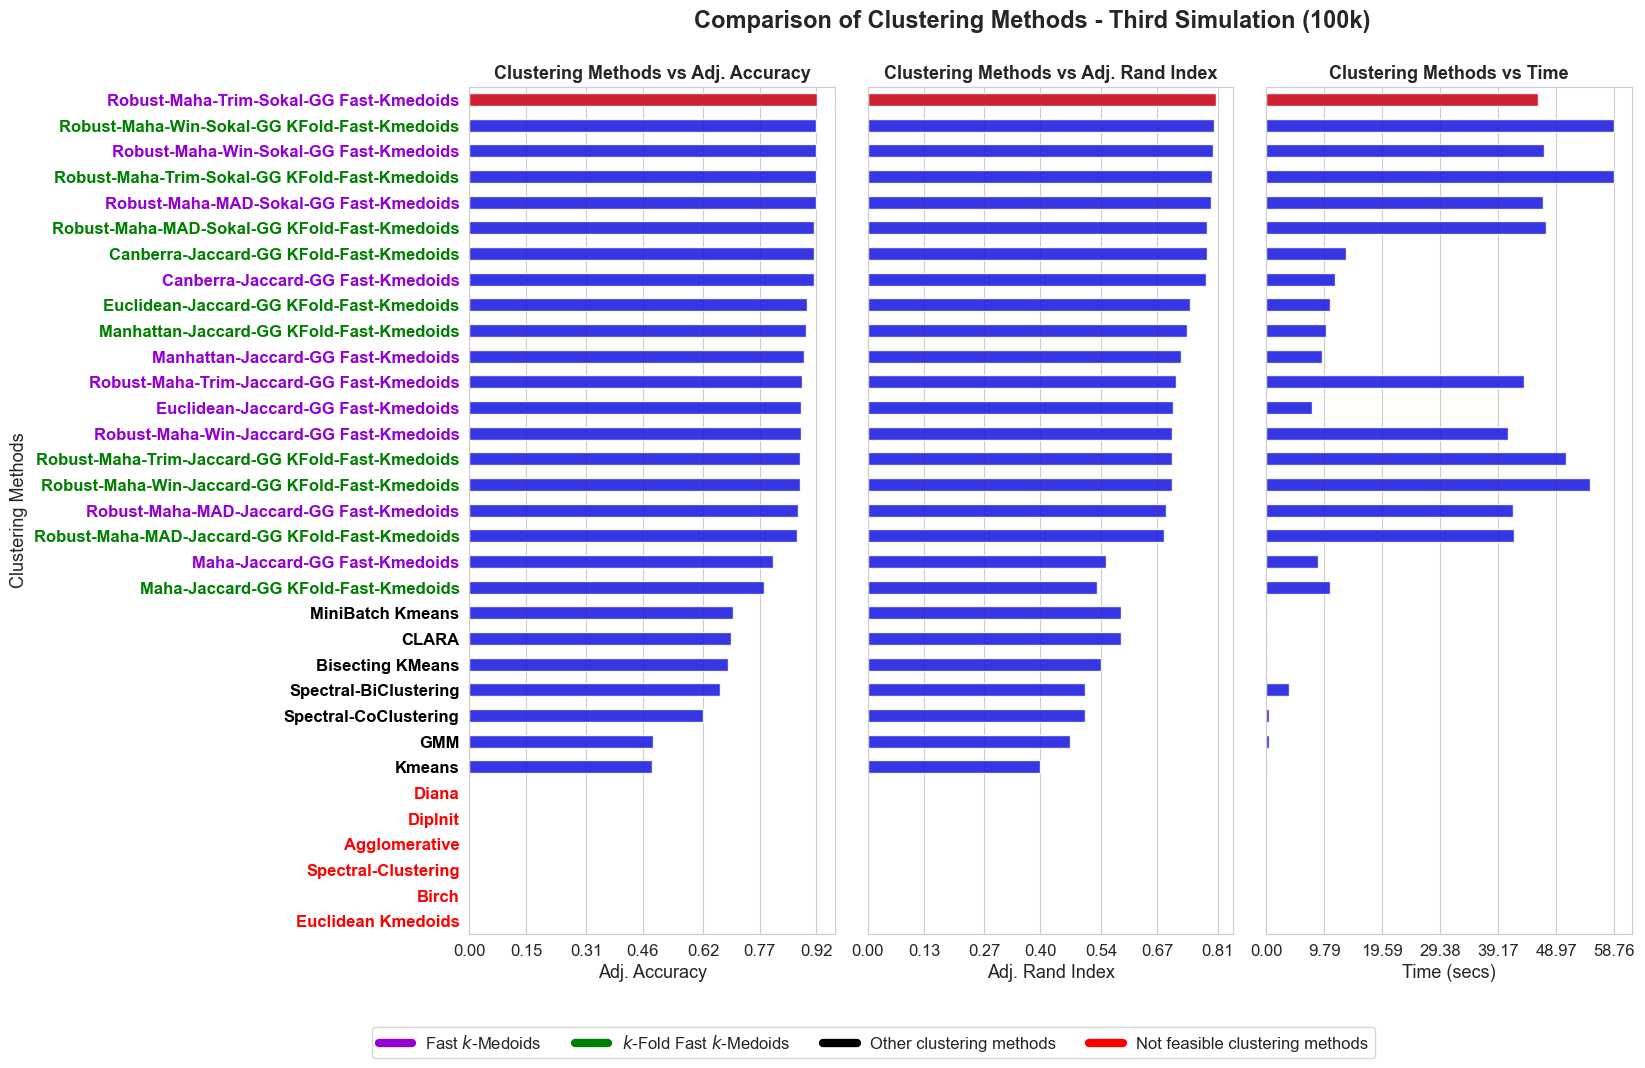

In [46]:
fig, axes = plt.subplots(1,3, figsize=(15,11))
axes = axes.flatten()

ax = sns.barplot(y=list(sorted_methods_accuracy), x=list(sorted_accuracies), color='blue', width=0.5, alpha=0.9, ax=axes[0])
ax = sns.barplot(y=[best_clustering_method], x=[accuracy_best_method], color='red', width=0.5, alpha=0.9, ax=axes[0])

ax = sns.barplot(y=list(sorted_methods_accuracy), x=adj_rand_index_list[np.argsort(-accuracy_list)], color='blue', width=0.5, alpha=0.9, ax=axes[1])
ax = sns.barplot(y=[best_clustering_method], x=[adj_rand_index_list[np.argmax(accuracy_list)]], color='red', width=0.5, alpha=0.9, ax=axes[1])

ax = sns.barplot(y=list(sorted_methods_accuracy), x=time_list[np.argsort(-accuracy_list)], color='blue', width=0.5, alpha=0.9, ax=axes[2])
ax = sns.barplot(y=[best_clustering_method], x=[time_list[np.argmax(accuracy_list)]], color='red', width=0.5, alpha=0.9, ax=axes[2])

axes[0].set_ylabel('Clustering Methods', size=13)
axes[0].set_xlabel('Adj. Accuracy', size=13)
axes[0].set_xticks(np.round(np.linspace(0, np.max(accuracy_list), 7),2)) 
axes[0].tick_params(axis='y', labelsize=12)    
axes[0].tick_params(axis='x', labelsize=12)  
axes[0].set_title('Clustering Methods vs Adj. Accuracy', size=13, weight='bold')

axes[1].set_xlabel('Adj. Rand Index', size=13)
axes[1].set_xticks(np.round(np.linspace(0, np.max(adj_rand_index_list), 7),2)) 
axes[1].tick_params(axis='x', labelsize=12)  
axes[1].set_title('Clustering Methods vs Adj. Rand Index', size=13, weight='bold')
axes[1].set_yticklabels([])

axes[2].set_xlabel('Time (secs)', size=13)
axes[2].set_xticks(np.round(np.linspace(0, np.max(time_list), 7),2)) 
axes[2].tick_params(axis='x', labelsize=12)  
axes[2].set_title('Clustering Methods vs Time', size=13, weight='bold')
axes[2].set_yticklabels([])

for label in axes[0].get_yticklabels():
    if label.get_text() in our_methods_1:
        label.set_weight('bold')
        label.set_color('darkviolet') 
    elif label.get_text() in our_methods_2:
        label.set_weight('bold')
        label.set_color('green') 
    elif label.get_text() in other_methods:
        label.set_weight('bold')
        label.set_color('black') 
    elif label.get_text() in not_feasible_methods:
        label.set_weight('bold')
        label.set_color('red') 

# Create legend elements
legend_elements = [
    plt.Line2D([0], [0], color='darkviolet', lw=6, label='Fast $k$-Medoids'),
    plt.Line2D([0], [0], color='green', lw=6, label='$k$-Fold Fast $k$-Medoids'),
    plt.Line2D([0], [0], color='black', lw=6, label='Other clustering methods'),
    plt.Line2D([0], [0], color='red', lw=6, label='Not feasible clustering methods')
]

# Add legend to the figure
axes[0].legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(2.5, -0.1), ncol=len(legend_elements), fontsize=12)

plt.suptitle("Comparison of Clustering Methods - Third Simulation (100k)", fontsize=17, weight='bold', y=0.95)
plt.subplots_adjust(hspace=0, wspace=0.09) 
file_name = 'plots/kmedoids_simulation_3_comparison'
fig.savefig(file_name + '.jpg', format='jpg', dpi=500, bbox_inches="tight", pad_inches=0.2)
plt.show()

## **MDS visualization of some of the algorithms**

In [47]:
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=123) 

fastGG = FastGG(frac_sample_size=0.03, random_state=111, p1=4, p2=2, p3=2, 
                 d1='robust_mahalanobis', d2='sokal', d3='matching', 
                 robust_maha_method='trimmed', alpha=0.05)

fastGG.compute(X)

X_mds = mds.fit_transform(fastGG.D_GG)

c:\Users\fscielzo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


In [53]:
our_methods_1_sorted_acc = [x for x in list(sorted_methods_accuracy) if x in our_methods_1]
our_methods_2_sorted_acc = [x for x in list(sorted_methods_accuracy) if x in our_methods_2]
other_methods_sorted_acc = [x for x in list(sorted_methods_accuracy) if x in other_methods]
best_our_methods_1 = our_methods_1_sorted_acc[0]
best_our_methods_2 = our_methods_2_sorted_acc[0]
best_other_methods = other_methods_sorted_acc[0]
additional_methods = ['Kmeans', 'GMM']

methods_to_plot = [best_our_methods_1, best_our_methods_2, best_other_methods] + additional_methods
names_to_plot = [('Best Fast-Kmedoids' if x in our_methods_1 else 'Best KFold-Fast-Kmedoids' if x in our_methods_2 else x) for x in methods_to_plot]
names_to_plot = dict(zip(methods_to_plot, names_to_plot))
y_pred_dict = {names_to_plot[method]: cluster_labels[method][fastGG.sample_index] for method in methods_to_plot}
accuracy_dict = {names_to_plot[method]: accuracy_cluster[method] for method in methods_to_plot}
time_dict = {names_to_plot[method]: time_cluster[method] for method in methods_to_plot}

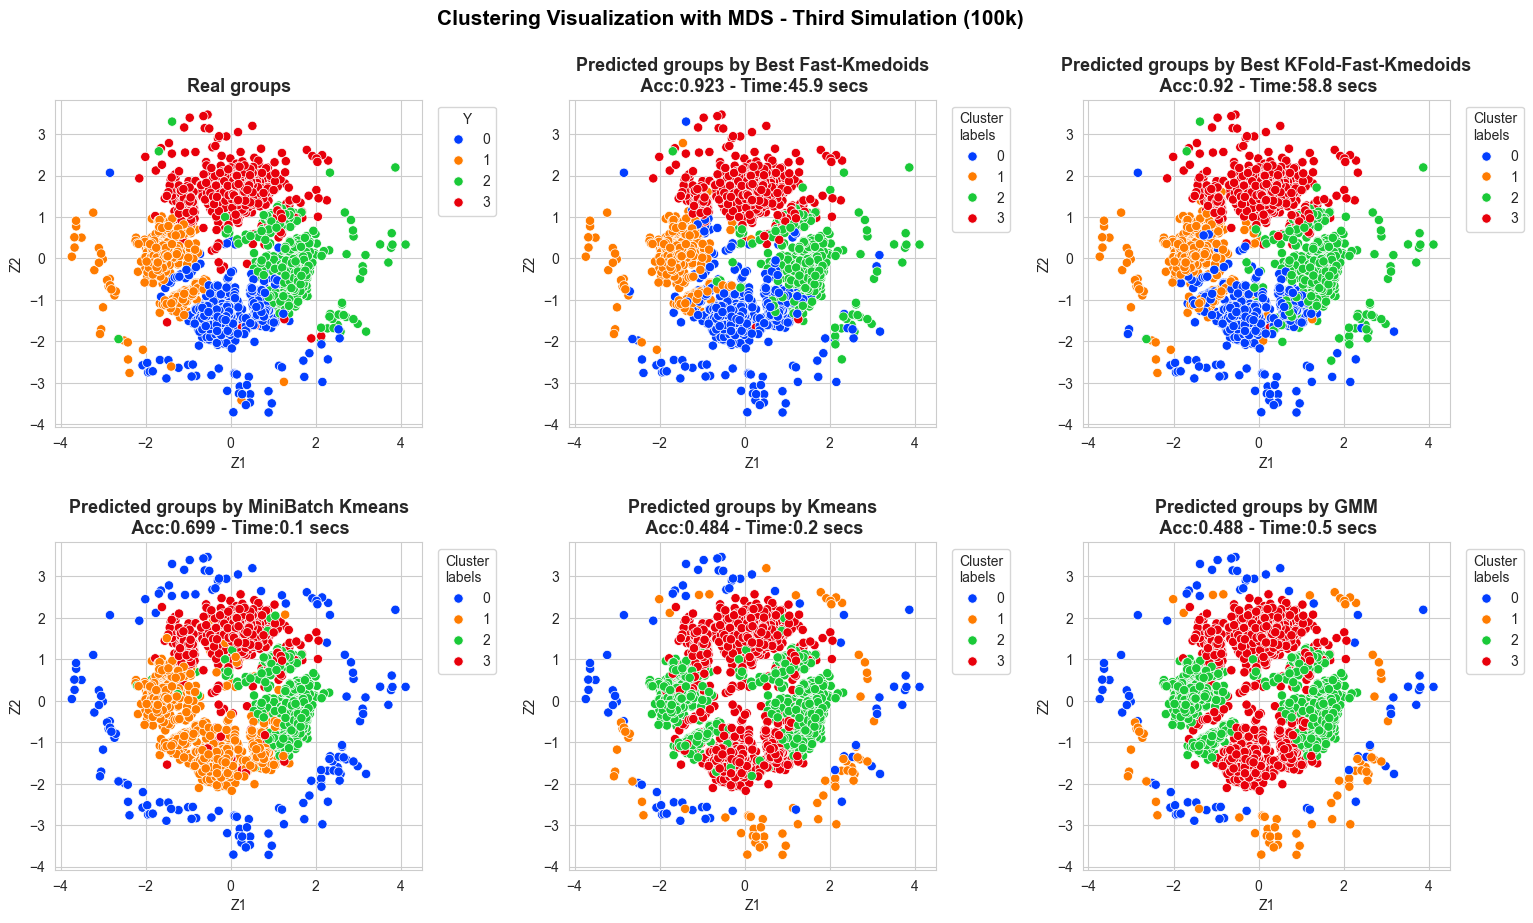

In [54]:
clustering_MDS_plot(X_mds=X_mds, y_pred=y_pred_dict, y_true=Y[fastGG.sample_index], 
                    title='Clustering Visualization with MDS - Third Simulation (100k)', 
                    accuracy=accuracy_dict, time=time_dict, 
                    figsize=(18, 10), n_rows=2, bbox_to_anchor=(1.22, 1), 
                    title_size=15, title_weight='bold', points_size=45, 
                    title_height=0.97, subtitles_size=13, subtitle_weight='bold',
                    hspace=0.35, wspace=0.4, save=True, file_name=f'plots/mds_plot_simulation_3.jpg')